## PART C: Convolutions in tensorflow

In this section we cover the basics of convolutions and will learn how to apply convolutions to an image using tensorflow. We will do this by implementing the [Sobel filter](https://en.wikipedia.org/wiki/Sobel_operator), which highlights edges in images. In the next step, we will try to optimise a set of convolutional filters such that they produce the same output as the Sobel filter. 

<h2> <u>Mount Google drive folder</u> </h2>


In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/ML_workshop

/content/drive/My Drive/ML_workshop


In [ ]:
ls

deep_learning/  machine_learning/


In [ ]:
# Import the required libraries

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

config=tf.ConfigProto()
config.gpu_options.allow_growth=True
config.allow_soft_placement=True

import numpy as np
import matplotlib.pyplot as plt

# Import acdc_data (need to add the lib package to the system path)
import os
import sys
module_path = os.path.abspath(os.path.join('.', './deep_learning/lib'))
# sys.path.append('../deep_learning/lib')
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
# Now we can import the module
import acdc_data

First, let's load a random 2D slice from the [ACDC Cardiac Segmentation Challenge](https://www.creatis.insa-lyon.fr/Challenge/acdc/) dataset and displaying it. 

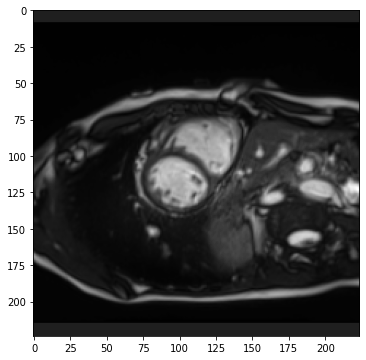

In [ ]:
# Test plotting stuff

img, mask = acdc_data.train.next_batch(batch_size=1)
img_disp = np.squeeze(img)  # The first dimensions contains the batch size, so we squeeze it away. 


plt.figure(figsize=(6, 6))
plt.imshow(img_disp, cmap='gray')
plt.show()

# If you don't like the image you can rerun the block

### 2D Convolutions 

Convolution is a very commonly used operation in signal processing. It let's us calculate the response of a **signal** to a **filter**. When dealing with images the signal ($f$) is the image and the filter ($h$) is a 2D array. The discrete 2D convolution is defined as:

$$ (f*h)[x,y] = \sum_{n_1} \sum_{n_2} f[n_1, n_2] h[x-n_1, y-n_2] $$

It can be easily understood graphically. The filter (dark blue) is shifted over the input image (blue), the kernel values and image values are multiplied at the current kernel position, summed up and placed into the output image (green) at that location. 

<img src="../images/full_padding_no_strides_transposed.gif" style="width: 250px;"/> 

(This animation was downloaded [here](https://github.com/vdumoulin/conv_arithmetic))

The Sobel filter calculates an approximation to the magnitude of the gradient of the image. More precisely, the image's intensity function. The gradients $G_x$, $G_y$ in $x$ and $y$ directions can be approximated by convolving the image with specific convolutional kernels. Namely:

$ G_x = \begin{bmatrix} 
 +1 & 0 & -1  \\
+2 & 0 & -2 \\
+1 & 0 & -1 
\end{bmatrix} * f
\quad
\mbox{and}
\quad   
G_y = \begin{bmatrix} 
 +1 & +2 & +1\\
 0 & 0 & 0 \\
-1 & -2 & -1
\end{bmatrix} * f $

The sobel filtered image is then given by the magnitude of the gradient:

$ S = \sqrt{G_x^2 + G_y^2} $ 

Next, we will create an expression that let's us filter an input image placeholder with placeholders for convolutional filters. 

Tensorflow provides us with a function to perform 2D convolutions called `tf.nn.conv2d`. The function operates on **4D tensors** assuming the following shape: `[batch_size, image_size_x, image_size_y, num_color_channels]`. Here is the syntax:

```python
conv2d(
    input,
    filter,
    strides,
    padding,
    use_cudnn_on_gpu=None,
    data_format=None,
    name=None
)
```

We see that the function requires four mandatory parameters: 
 - **input**: image placeholder, 
 - **filter**: filter weights placeholder/variable. Should have the following shape `[kernel_size_x, kernel_size_y, input_dimensions, output_dimensions]`. 
 - **strides**: numpy array defining the size of steps to make in each direction. For us this should be `[1,1,1,1]`.
 - **padding**: this option defines how the operation deals with the borders. If set to `'VALID'` the output image shrinks because the convolutional filter cannot be evaluated at the image borders. If set to `SAME` the input image will be padded with zeros such that the output size is the same as the input size. 
 
Below, implement the expressions for `G_x_pl` and `G_y_pl`. Use `padding='VALID'` for now, but `SAME` would work just as well. Furthermore, evaluate the two expressions in a session, and plot the results. 

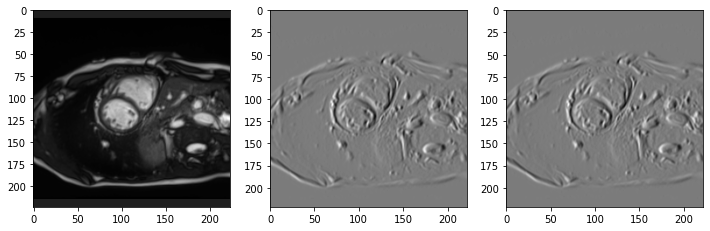

The input image was of shape:
(224, 224)
The output images have the following shape
(222, 222)


In [ ]:
img_pl = tf.placeholder(tf.float32)
h_x_pl = tf.placeholder(tf.float32)
h_y_pl = tf.placeholder(tf.float32)

### IMPLEMENT TENSORFLOW EXPRESSION FOR G_x_pl and G_y_pl ###
G_x_pl = tf.nn.conv2d(img_pl, h_x_pl, strides=(1,1,1,1), padding='VALID')
G_y_pl = tf.nn.conv2d(img_pl, h_x_pl, strides=(1,1,1,1), padding='VALID')
#############################################################

H_x = np.array([[-1,  0, 1],
              [-2,  0, 2],
              [-1,  0, 1]])
H_x = np.reshape(H_x, (3, 3, 1, 1)) 

H_y = np.array([[-1, -2, -1],
              [  0,  0, 0],
              [  1,  2, 1]])
H_y = np.reshape(H_y, (3, 3, 1, 1))  

F = np.expand_dims(img, axis=-1)  # add the missing color channel

with tf.Session(config=config) as sess:
    
    ### EVALUATE G_x_eval, G_y_eval USING THE TF.SESSION ###
    # Remember that you can evaluate multiple tensorflow objects simultaneously
    # by using sess.run([a,b], feed_dict={ "required inputs" })
    # Don't forget to feed the values the actual filter values and the input image to the expression 
    
    [G_x_eval, G_y_eval] = sess.run([G_x_pl, G_y_pl], feed_dict={img_pl: F,
                                                                 h_x_pl: H_x, 
                                                                 h_y_pl: H_y})   # implement this
    
    ########################################################
    
# Display the result
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(img), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(np.squeeze(G_x_eval), cmap='gray')
plt.subplot(1,3,3)
plt.imshow(np.squeeze(G_y_eval), cmap='gray')
plt.show()

print('The input image was of shape:')
print(np.squeeze(img).shape)
print('The output images have the following shape')
print(np.squeeze(G_x_eval).shape)  # One pixel at each border got lost

Now create an expression for the Sobel filtered image ($ S = \sqrt{G_x^2 + G_y^2} $ ) and evalate that expression. You will need the `tf.sqrt` function.

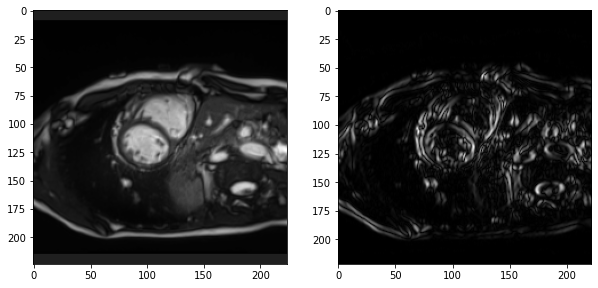

In [ ]:
### IMPLEMENT THIS ###
sobel_pl = tf.sqrt(G_x_pl**2 + G_y_pl**2)
######################

with tf.Session(config=config) as sess:

    sobel_eval = sess.run(sobel_pl, feed_dict={img_pl: F, h_x_pl: H_x, h_y_pl: H_y})

# Display the result
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(np.squeeze(img), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(np.squeeze(sobel_eval), cmap='gray')
plt.show()

### Learning the parameters of convolutional filters

Now that we successfully created a Sobel filtered image, let's try a different approach. Suppose someone gave you the two images above without telling you anything about how the one on the right was generated. Could we optimise the parameters of our convolutional filters until they perform the same operation. That is, can be learn the Sobel filtering operation?

Let's start by generating Filter **Variables**, rather than placeholders. Recall that the value of variables can be optimised as opposed to placeholders which have no value, and numpy arrays which are not part of tensorflow computational graphs. In the example below note, that we don't initialise the Variables as a constant, but we initialise with random numbers from a random distribution with a standard deviation of one. In this example, initialisation doesn't have a huge impact. However, in deep convolutional neural networks such as the one in part E of this practical, or even in the smaller multi layer perceptron in part B, the initial distribution of the variables plays a significant role. 

In addition to the input image placeholder, now, we will also need a placeholder for the target image (i.e. the Sobel filtered output). 


In [ ]:
tf.reset_default_graph()
sess.close()

h_x_var = tf.Variable(tf.truncated_normal([3, 3, 1, 1], stddev=0.1, name='filter_x'))
h_y_var = tf.Variable(tf.truncated_normal([3, 3, 1, 1], stddev=0.1, name='filter_y'))

img_pl = tf.placeholder(tf.float32)  # already defined above, but repeated here for clarity
target_pl = tf.placeholder(tf.float32)  # Will hold the ground-truth Sobel filtered image

Also, let us redefine the Sobel filter operation with the filter **variables**. 

In [ ]:
### IMPLEMENT THIS ###
# Redefine the expressions for the filtered images and the Sobel filter output using the newly defined filter Variables
G_x_pl = tf.nn.conv2d(img_pl, h_x_var, strides=(1,1,1,1), padding='VALID')
G_y_pl = tf.nn.conv2d(img_pl, h_y_var, strides=(1,1,1,1), padding='VALID')
sobel_pl = tf.sqrt(G_x_pl**2 + G_y_pl**2)
######################

We want to find a set of filters `h_x_var` and `h_y_var` that produce the same output as the Sobel filter from above. In order to solve this problem we first need to define what a good/bad network output is. This means we first need to define a loss function. Since we want the Sobel filtered image `sobel_pl` to be as similar as possible to the target (or ground-truth) Sobel filtered image from above `target_pl`, we can simply use the mean squared error (MSE) loss which is defined as: 

$ L(f,g) = \frac{1}{N} \sum_{i,j} (f_{ij}-g_{ij})^2, $

where $N$ is the number of pixels in the image. The mean of all elements of a tensor can be calculated using the `tf.reduce_mean(tensor)` function. 

Once we have defined a loss, tensorflow gives us convenient tools to minimise it. Arguably, the simplest (but not necessarily the best) method to minimise any cost function is gradient descent, in which in each step the gradient of the cost function w.r.t to the parameters is calculated, multiplied with a learning rate, and then subtracted from current parameter values. Here, we use gradient descent with momentum, which is similar but also takes past gradient updates into account. Good values for the learning rate and to a lesser degree the momentum term, are hugely important and can make all the difference for successful training.

In [ ]:
### IMPLEMENT THIS ###
loss_pl = tf.reduce_mean((target_pl - sobel_pl)**2)
######################

optimiser = tf.train.AdamOptimizer(learning_rate=0.001)
training_op = optimiser.minimize(loss_pl)  # each time this is called a gradient update is performed

# Prepare input images again 
F = np.expand_dims(img, axis=-1)  # add the missing colour channel
S_gt = sobel_eval # the ground-truth Sobel filter output evaluated above

Now that we have a training operation we can run a loop over several iterations to minimise the cost function. In the example below insert the training operation and in the same `run` call also retrieve the current loss. 

In order to also keep visual track of the optimisation, let's evaluate and plot the filtered image every 500 steps. 

iter: 0, loss: 2.474055


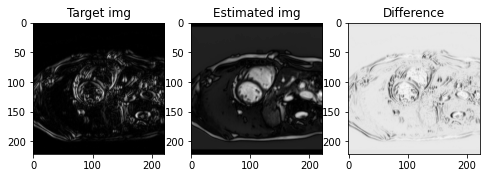

iter: 100, loss: 2.179869
iter: 200, loss: 2.138095
iter: 300, loss: 2.024306
iter: 400, loss: 1.829927
iter: 500, loss: 1.571702


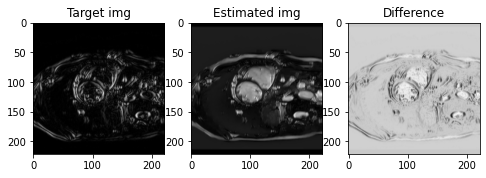

iter: 600, loss: 1.293284
iter: 700, loss: 1.032414
iter: 800, loss: 0.806859
iter: 900, loss: 0.620220
iter: 1000, loss: 0.469769


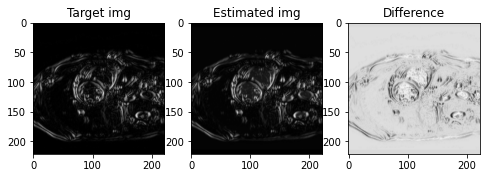

iter: 1100, loss: 0.350719
iter: 1200, loss: 0.258026
iter: 1300, loss: 0.186993
iter: 1400, loss: 0.133460
iter: 1500, loss: 0.093844


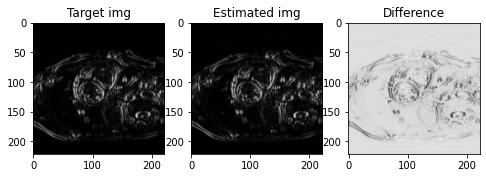

iter: 1600, loss: 0.065102
iter: 1700, loss: 0.044691
iter: 1800, loss: 0.030527
iter: 1900, loss: 0.020932
iter: 2000, loss: 0.014595


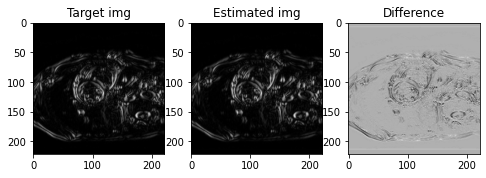

iter: 2100, loss: 0.010516
iter: 2200, loss: 0.007957
iter: 2300, loss: 0.006391
iter: 2400, loss: 0.005454
iter: 2500, loss: 0.004901


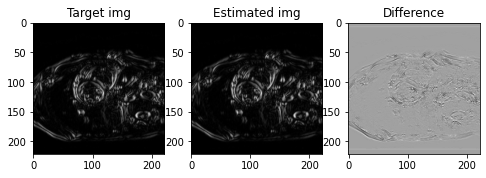

iter: 2600, loss: 0.004575
iter: 2700, loss: 0.004379
iter: 2800, loss: 0.004252
iter: 2900, loss: 0.004163
iter: 3000, loss: 0.004092


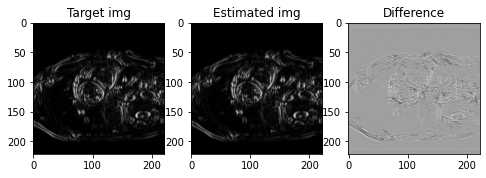

iter: 3100, loss: 0.004030
iter: 3200, loss: 0.003971
iter: 3300, loss: 0.003913
iter: 3400, loss: 0.003856
iter: 3500, loss: 0.003797


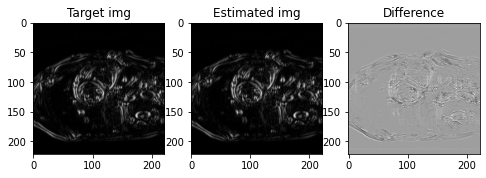

iter: 3600, loss: 0.003737
iter: 3700, loss: 0.003676
iter: 3800, loss: 0.003614
iter: 3900, loss: 0.003549
iter: 4000, loss: 0.003484


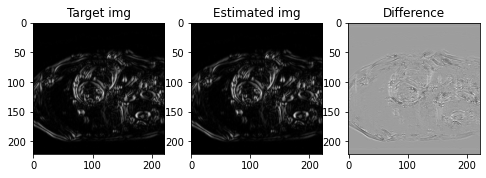

iter: 4100, loss: 0.003416
iter: 4200, loss: 0.003347
iter: 4300, loss: 0.003277
iter: 4400, loss: 0.003204
iter: 4500, loss: 0.003130


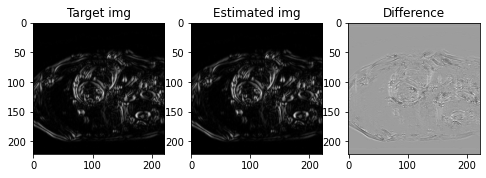

iter: 4600, loss: 0.003053
iter: 4700, loss: 0.002975
iter: 4800, loss: 0.002896
iter: 4900, loss: 0.002814
iter: 5000, loss: 0.002731


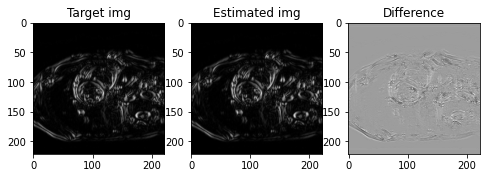

iter: 5100, loss: 0.002647
iter: 5200, loss: 0.002561
iter: 5300, loss: 0.002474
iter: 5400, loss: 0.002385
iter: 5500, loss: 0.002295


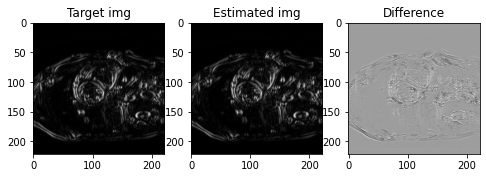

iter: 5600, loss: 0.002205
iter: 5700, loss: 0.002113
iter: 5800, loss: 0.002021
iter: 5900, loss: 0.001929
iter: 6000, loss: 0.001836


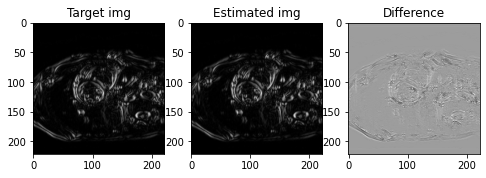

iter: 6100, loss: 0.001743
iter: 6200, loss: 0.001651
iter: 6300, loss: 0.001560
iter: 6400, loss: 0.001469
iter: 6500, loss: 0.001379


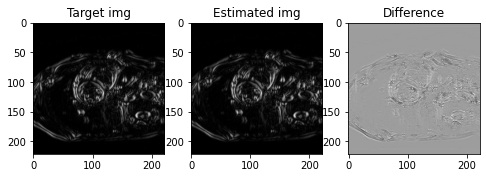

iter: 6600, loss: 0.001290
iter: 6700, loss: 0.001203
iter: 6800, loss: 0.001118
iter: 6900, loss: 0.001036
Loss below threshold. Exiting optimisation


In [ ]:
epsilon = 0.0000001

init_op = tf.global_variables_initializer()  # since we now have variables again we need an init operation

sess = tf.Session(config=config)

sess.run(init_op)

for iter in range(10000):

    loss, _ = sess.run([loss_pl, training_op], feed_dict={img_pl: F + epsilon, target_pl: S_gt})  # implement this
    
    if iter % 100 == 0:
        print("iter: %d, loss: %f" %(iter, loss))

    if iter % 500 == 0:
        sobel_approx = sess.run(sobel_pl, feed_dict={img_pl: F})
        plt.figure(figsize=(8,6))
        plt.subplot(1,3,1)
        plt.imshow(np.squeeze(S_gt), cmap='gray')
        plt.title('Target img')
        plt.subplot(1,3,2)
        plt.imshow(np.squeeze(sobel_approx), cmap='gray')
        plt.title('Estimated img')
        plt.subplot(1,3,3)
        plt.imshow(np.squeeze(sobel_approx)-np.squeeze(S_gt), cmap='gray')
        plt.title('Difference')
        plt.show()

    if loss < 0.001:
        print("Loss below threshold. Exiting optimisation")
        break

You see that this optimisation very quickly learns to produce a reasonably close approximation to the Sobel filter. Does that mean that it learned exactly the same filters as the Sobel filter? Think about this for a second. Is the solution unique? 

Now let us have a look at the original filters and at the learned filters. In order to get the actual values of the filter variables we need to evaluated them in our session. 

The original gradient operations in x and y direction looked like this:


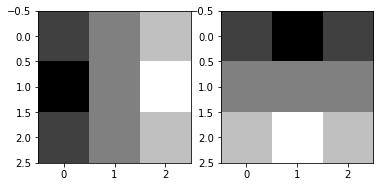

The newly learned filters look like this


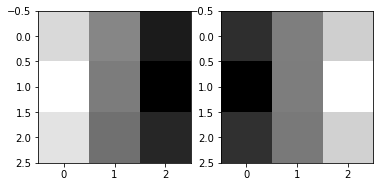

In [ ]:
# Evaluating the value of the learned convolutional filters
H_x_approx = sess.run(h_x_var) 
H_y_approx = sess.run(h_y_var) 

# Displaying original and new filters
print('The original gradient operations in x and y direction looked like this:')

plt.subplot(121)
plt.imshow(np.squeeze(H_x), cmap='gray')
plt.subplot(122)
plt.imshow(np.squeeze(H_y), cmap='gray')
plt.show()

print('The newly learned filters look like this')
plt.subplot(121)
plt.imshow(np.squeeze(H_x_approx), cmap='gray')
plt.subplot(122)
plt.imshow(np.squeeze(H_y_approx), cmap='gray')
plt.show()

You will notice that even though the output of the operation looks almost exactly the same the learned filters are most likely different from the original ones. This is due to the fact that taking the gradient in X and Y directions is an arbitrary definition set by us. We may as well take the the gradient in the directions rotated by 45 degrees or any other angle.

Even though this was a relatively simple example, training convolutional neural networks follows almost exactly the same principles. The main difference is that the output of one of the convolutional layers serves as the input to the next convolutional layer (after being modified by a non-linearity function). 

Similar, to this example convolutional kernels in for machine learning tasks will converge to whatever is "best" for the task. However, there is no unique solution. 

In [ ]:
sess.close()